In [1]:
import keras
from keras.models import Model, Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.layers.merge import _Merge
import keras.backend as K
from functools import partial
import numpy as np

import matplotlib.pyplot as plt
from keras.utils import plot_model
%matplotlib inline

Using TensorFlow backend.


In [19]:
class DAWGANGP():
    def __init__(self):
        self.d_history = []
        self.g_history = []

        self.img_rows = 1024
        self.img_cols = 1
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.feature_dim = 256
        self.nb_classes = 3

        self.n_discriminator = 5

        optimizer = Adam()
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.classifier = self.build_classifier()

        #-------------------------------
        # Construct Computational Graph
        #       for the discriminator
        #-------------------------------

        self.generator.trainable = False

        # source input
        source_img_d = layers.Input(shape=self.img_shape)
        source_feature = self.generator(source_img_d)

        # target input
        target_img_d = layers.Input(shape=self.img_shape)
        target_feature = self.generator(target_img_d)
        
        valid_source = self.discriminator(source_feature)
        valid_target = self.discriminator(target_feature)


        self.discriminator_model = Model(inputs=[source_img_d, target_img_d],
                            outputs=[valid_source, valid_target])
        
        self.discriminator_model.compile(loss=['binary_crossentropy',
                                              'binary_crossentropy'],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1])
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        self.discriminator.trainable = False
        self.classifier.trainable = True
        self.generator.trainable = True
        
        # source input
        source_im_g = layers.Input(shape=self.img_shape)
        source_feature_g = self.generator(source_im_g)

        # target input
        target_img_g = layers.Input(shape=self.img_shape)
        target_feature_g = self.generator(target_img_g)
       
        # classifier
        source_label_g = self.classifier(source_feature_g)
        
        valid_target_g = self.discriminator(target_feature_g)
        
        self.generator_model = Model(inputs=[source_im_g, target_img_g], 
                                    outputs=[source_label_g, valid_target_g])
        
        self.generator_model.compile(loss=[categorical_crossentropy, 'binary_crossentropy'],
                                     optimizer=optimizer, loss_weights=[1, 1])
        
        
        #-------------------------------
        # Construct Computational Graph
        #         for classifier
        #-------------------------------
        self.generator.trainable = True
        self.classifier.trainable = True
        
        # source input
        source_img_c = layers.Input(shape=self.img_shape)
        source_feature_c = self.generator(source_img_c)
        source_label_c = self.classifier(source_feature_c)
        
        self.classifier_model = Model(source_img_c, source_label_c)
        self.classifier_model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
          
              
    
    def build_generator(self): 
        model = Sequential()
        model.add(layers.Conv2D(filters=64, kernel_size=(8,1), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Conv2D(filters=128, kernel_size=(5,1), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Conv2D(filters=256, kernel_size=(3,1), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.pooling.GlobalAveragePooling2D())
               
        model.add(layers.Dense(self.feature_dim))
        model.add(layers.Activation(activation='tanh'))

        sig = layers.Input(shape=self.img_shape)
        feature = model(sig)
        #model.summary()
        
        return Model(sig, feature)
    
    def build_discriminator(self):

        model = Sequential()
        model.add(layers.Dense(128))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.Dense(1))
        model.add(layers.Activation(activation='sigmoid'))
        
        feature = layers.Input(shape=(self.feature_dim,))
        validity = model(feature)
        #model.summary()

        return Model(feature, validity)
    
    def build_classifier(self):

        model = Sequential()
        model.add(layers.Dense(self.nb_classes, activation='softmax'))

        feature = layers.Input(shape=(self.feature_dim,))
        cls = model(feature)
        #model.summary()

        return Model(feature, cls)
    
    
    def train(self, epochs, batch_size, sample_interval=50):
        

        # Load source dataset
        X_source = np.load('./data/x_007_1.npy')
        Y_source = np.load('./data/y_007_1.npy')
        
        X_source = X_source.reshape(X_source.shape[0], X_source.shape[1], 1, 1) # (nb_samples, rows, cols, channels)

        # Rescale -1 to 1
        X_source = X_source.astype(np.float32) / 10
        
        Y_source = keras.utils.to_categorical(Y_source, self.nb_classes)
        # Load target dataset        
        X_target = np.load('./data/fan_x_007_1.npy')
        Y_target = np.load('./data/fan_y_007_1.npy')
        
        X_target = X_target.reshape(X_target.shape[0], X_target.shape[1], 1, 1) # (nb_samples, rows, cols, channels)
        
        X_target = X_target.astype(np.float32) / 10
        
        Y_target = keras.utils.to_categorical(Y_target, self.nb_classes)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake =  np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            for _ in range(2):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_source.shape[0], batch_size)
                
                source_imgs = X_source[idx]
                source_labels = Y_source[idx]
                
                idx2 = np.random.randint(0, X_target.shape[0], batch_size)
                target_imgs = X_target[idx2]
                target_labels = Y_target[idx2]
                
                # Train the Discriminator
                d_loss = self.discriminator_model.train_on_batch([source_imgs, target_imgs],
                                                                [valid, fake])

            # ---------------------
            #  Train Generator
            # ---------------------
            g_loss = self.generator_model.train_on_batch([source_imgs, target_imgs], [source_labels, valid])
                              
            score = self.classifier_model.test_on_batch(source_imgs, source_labels)
            
            score2 = self.classifier_model.test_on_batch(target_imgs, target_labels)
            
            self.g_history.append(g_loss[0])
            self.d_history.append(d_loss[0])

            # Plot the progress
            if epoch % 50 == 0:
                print ("%d [D loss: %f] [G loss: %f] [C_s loss: %f] [C_s acc: %f] [C_t loss: %f] [C_t acc: %f]" %
                       (epoch, d_loss[0], g_loss[0], score[0], score[1], score2[0], score2[1]))

            
            
        score_source = self.classifier_model.evaluate(X_source, Y_source, verbose=0)
        print('============================')
        print('C_s loss:', score_source[0])
        print('accuracy:', score_source[1])
        
        score_target = self.classifier_model.evaluate(X_target, Y_target, verbose=0)
        print('C_t loss:', score_target[0])
        print('accuracy:', score_target[1])
        print('============================')        

In [20]:
net = DAWGANGP()

net.train(epochs=500, batch_size=128)

0 [D loss: 1.546360] [G loss: 2.198023] [C_s loss: 0.964255] [C_s acc: 0.343750] [C_t loss: 1.070163] [C_t acc: 0.304688]
50 [D loss: 1.400421] [G loss: 0.783172] [C_s loss: 1.292012] [C_s acc: 0.750000] [C_t loss: 4.902675] [C_t acc: 0.335938]
100 [D loss: 1.256177] [G loss: 0.805949] [C_s loss: 3.822488] [C_s acc: 0.343750] [C_t loss: 4.225333] [C_t acc: 0.578125]
150 [D loss: 1.336362] [G loss: 0.813775] [C_s loss: 9.677583] [C_s acc: 0.320312] [C_t loss: 9.553829] [C_t acc: 0.320312]
200 [D loss: 1.294157] [G loss: 0.797148] [C_s loss: 7.916143] [C_s acc: 0.343750] [C_t loss: 8.455848] [C_t acc: 0.375000]
250 [D loss: 1.292152] [G loss: 0.831531] [C_s loss: 5.077703] [C_s acc: 0.671875] [C_t loss: 8.066207] [C_t acc: 0.359375]
300 [D loss: 1.345093] [G loss: 0.773465] [C_s loss: 7.307909] [C_s acc: 0.335938] [C_t loss: 9.538733] [C_t acc: 0.328125]
350 [D loss: 1.372450] [G loss: 0.745058] [C_s loss: 10.325655] [C_s acc: 0.359375] [C_t loss: 9.696042] [C_t acc: 0.398438]
400 [D los

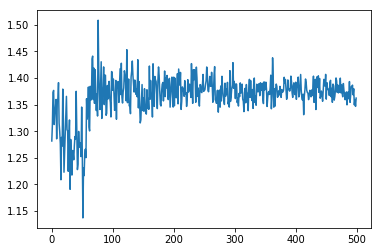

In [16]:
plt.plot(net.d_history)

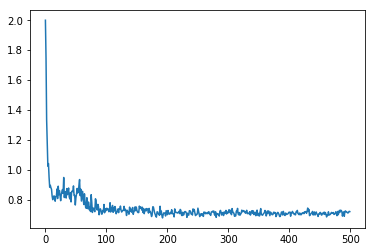

In [17]:
plt.plot(net.g_history)

# without transfer

train on source

test on target

In [18]:
X_source = np.load('./data/x_007_1.npy')
Y_source = np.load('./data/y_007_1.npy')
X_source = X_source.reshape(X_source.shape[0], X_source.shape[1], 1, 1) # (nb_samples, rows, cols, channels)
# Rescale -1 to 1
X_source = X_source.astype(np.float32) / 10
Y_source = keras.utils.to_categorical(Y_source, 3)

X_target = np.load('./data/fan_x_007_1.npy')
Y_target = np.load('./data/fan_y_007_1.npy')

X_target = X_target.reshape(X_target.shape[0], X_target.shape[1], 1, 1) # (nb_samples, rows, cols, channels)

X_target = X_target.astype(np.float32) / 10
Y_label = Y_target
Y_target = keras.utils.to_categorical(Y_target, 3)

np.random.seed(42)

net2 = DAWGANGP()
net2.classifier_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

net2.classifier_model.fit(X_source, Y_source, batch_size=128, epochs=20,shuffle=True ,
                         validation_data=(X_target, Y_target))

Train on 4500 samples, validate on 4464 samples
Epoch 1/20
4500/4500 [==============================] - 4s 803us/step - loss: 0.0859 - acc: 0.9716 - val_loss: 2.1427 - val_acc: 0.6225
Epoch 2/20
4500/4500 [==============================] - 2s 460us/step - loss: 2.2662e-04 - acc: 1.0000 - val_loss: 1.5981 - val_acc: 0.6788
Epoch 3/20
4500/4500 [==============================] - 2s 461us/step - loss: 1.5161e-04 - acc: 1.0000 - val_loss: 1.4828 - val_acc: 0.6886
Epoch 4/20
4500/4500 [==============================] - 2s 460us/step - loss: 1.1144e-04 - acc: 1.0000 - val_loss: 1.4749 - val_acc: 0.6933
Epoch 5/20
4500/4500 [==============================] - 2s 461us/step - loss: 8.6585e-05 - acc: 1.0000 - val_loss: 1.4946 - val_acc: 0.6938
Epoch 6/20
4500/4500 [==============================] - 2s 460us/step - loss: 6.9162e-05 - acc: 1.0000 - val_loss: 1.5115 - val_acc: 0.6938
Epoch 7/20
4500/4500 [==============================] - 2s 461us/step - loss: 6.1126e-05 - acc: 1.0000 - val_loss: 1

# 特征可视化

In [10]:
Xs = net.generator.predict(X_source)
Xt = net.generator.predict(X_target)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

In [12]:
Xs = Xs[::5]
Xt = Xt[::5]

Xs = Xs.reshape((Xs.shape[0], Xs.shape[1]))
Xt = Xt.reshape((Xt.shape[0], Xt.shape[1]))

X = np.vstack([Xs, Xt])

In [13]:
X.shape

(1793, 256)

In [14]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)

In [15]:
X_tsne.shape

(1793, 2)

In [16]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
X_tsne = X_norm

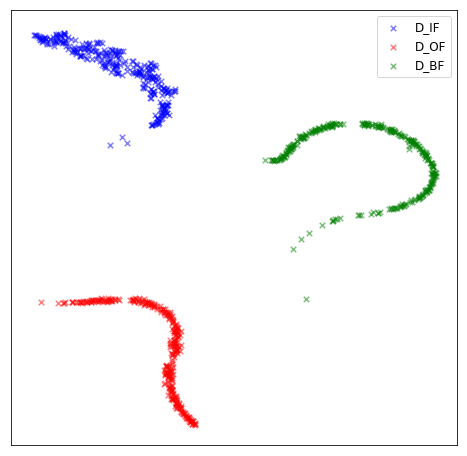

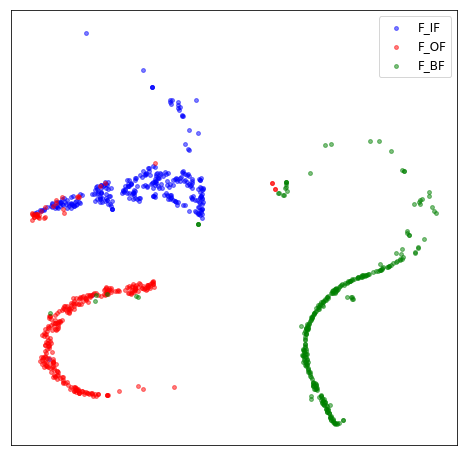

In [17]:
plt.figure(figsize=(8,8))

step = 300
p = 0
q = step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='x',s=30, alpha=0.5,c='blue', label = 'D_IF')

p += step
q += step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='x',s=30, alpha=0.5,c='red', label = 'D_OF')

p += step
q += step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='x',s=30, alpha=0.5,c='green', label = 'D_BF')

plt.xticks([])
plt.yticks([])
plt.legend(fontsize = 12)

plt.figure(figsize=(8,8))
p += step
q += step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='o',s=15, alpha=0.5,c='blue', label = 'F_IF')

p += step
q += step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='o',s=15, alpha=0.5,c='red', label = 'F_OF')

p += step
q += step
plt.scatter(X_tsne[p:q,0], X_tsne[p:q,1], marker='o',s=15, alpha=0.5,c='green', label = 'F_BF')





#plt.scatter(X_tsne[:900,0], X_tsne[:900,1], marker='x',s=15, alpha=0.5,c=ys, label = 'source')
#plt.scatter(X_tsne[900:,0], X_tsne[900:,1], s=15, alpha=0.5,c=yt, label = 'target')

plt.xticks([])
plt.yticks([])
plt.legend(fontsize = 12)